# Statistical Pattern Recognition Project
**Title**    : Clustering Methods

**Members**  : Jayanth S, Praveen Kumar N, Rishabh Roy

# Importing:

In [8]:
import numpy as np
import pandas as pd
import math
import matplotlib
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering

from IPython.display import Javascript
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [9]:
def avoid_scroll_output_window():
  # To avoid the scroll in the ouput window of each cell
  display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))

# Data Generation:

### Function to generate points on circle with noise:

In [10]:
def NoisyPtsonCirle(r,n):
    return [(math.cos(2*math.pi/n*x)*r+np.random.normal(-30,30),math.sin(2*math.pi/n*x)*r+np.random.normal(-30,30)) for x in range(1,n+1)]


### Generating concentric circles dataset:

In [11]:
np.random.seed(42)
# Creating data set in the form of concentric circles
dataset = pd.DataFrame((NoisyPtsonCirle(500,1000)))   # 1000 X 2
dataset = dataset.append((NoisyPtsonCirle(300,700)))  # 1700 X 2 
dataset = dataset.append((NoisyPtsonCirle(100,300)))  # 2000 x 2 

# Adding noise to the dataset
dataset = dataset.append([(np.random.randint(-600,600),np.random.randint(-600,600)) for i in range(300)])  # 2300 X 2

labels = np.concatenate((0*np.ones((1000,1),dtype='int'),1*np.ones((700,1),dtype='int'),2*np.ones((300,1),dtype='int'),3*np.ones((300,1),dtype='int')),axis = 0 ) # 2300 X 1

dataset_np = np.array(dataset) # 2300 X 2

### Plotting dataset and the true clusters:

<IPython.core.display.Javascript object>

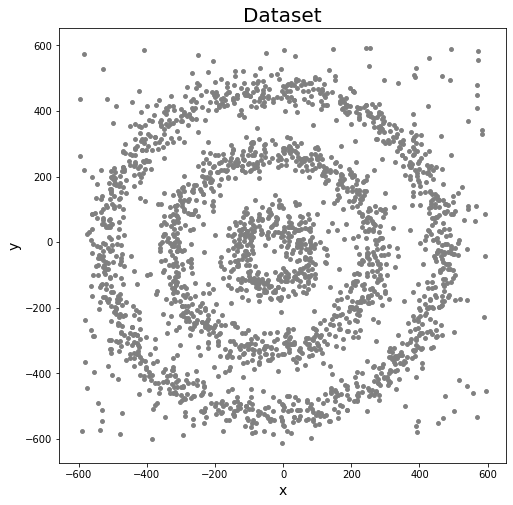

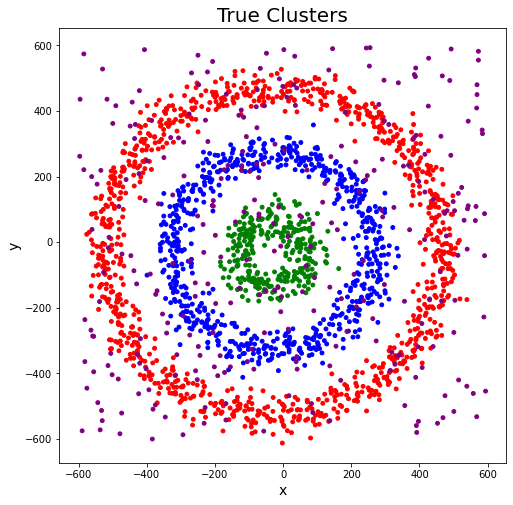

In [12]:
colors=['red','blue','green','purple']
avoid_scroll_output_window()

plt.figure(figsize=(8,8))
plt.scatter(dataset[0],dataset[1],s=15,color='grey')
plt.title('Dataset',fontsize=20)
plt.xlabel('x',fontsize=14)
plt.ylabel('y',fontsize=14)
plt.show()

plt.figure(figsize=(8,8))
plt.scatter(dataset[0],dataset[1],c=labels,cmap=matplotlib.colors.ListedColormap(colors),s=15)
plt.title('True Clusters',fontsize=20)
plt.xlabel('x',fontsize=14)
plt.ylabel('y',fontsize=14)
plt.show()

# Clustering Methods built from scratch:

## Heirarchical clustering:

In [13]:
def distance_cal(clusters):
  NS = len(clusters) # No. of clusters there in samples
  dist_mat = np.zeros((NS,NS))
  d = 2
  """Single Linkage criteria is used with euclidean distance as the metric"""

  # print(f"No. of clusters : {NS}")
  for i in range (NS):
    x = clusters[i]  #contains all the elements in cluster i
    
    x = np.array(x)  # convert the item of the list into an array
    x = x[np.newaxis, :] #since data can be 1-dim add new axis to it
    if len(x.shape)>2:
      x =x[0,:,:]    #if the item is 2-dim then remove the new dim that is added
    # x = np.reshape(x,(x_len,d))
    # print(f"No. of samples in ith cluster : {x.shape}")
    N_i = x.shape[0]   # no. of elements in cluster x
    for j in range (i):
      
      y = clusters[j]  #contains all the elements in cluster i
    
      y = np.array(y)
      y = y[np.newaxis, :]
      if len(y.shape)>2:
        y =y[0,:,:]
      # print(f"No. of samples in jth cluster : {y.shape}")

      N_j = y.shape[0]   # No. of elements in cluster y
      # print(N_i,N_j)
      # print(f"samples in cluster x : {x}")

      linkage_ij = np.zeros((N_i,N_j))   # matrix containing distance between each element in ith cluster and jth cluster
      for k in range(N_i):
        xk = x[k,:]  #pick kth element in cluster x
        # print(xk)
        # print(f"shape : {xk.shape}")
        # xk =xk.reshape(1,len(xk))
        # print(f"xk : {xk}") 
        for l in range (N_j):
          yk = y[l,:] #pick lth element in cluster y
          # print(yk)
          # print(f"shape : {yk.shape}")
          dist_xkyk = np.sqrt(np.dot(xk,xk)-2*np.dot(xk,yk)+np.dot(yk,yk))
          # print(dist_xkyk)
          linkage_ij[k,l] = dist_xkyk   
       
      #Since we are using single linkage criterion we say distance between 
      #cluster x and cluster y is minimum distance among all
      dist_mat[i,j] =np.mean(linkage_ij)  #change to np.max for complete linkage
      dist_mat[j,i] =dist_mat[i,j]
  return dist_mat


## Density-Based Spatial Clustering of Applications with Noise(DBSCAN):

In [14]:
class MyDBSCAN():
    """A density based clustering method that expands clusters from 
    samples that have more neighbors within a radius specified by eps
    than the value min_samples.
    Parameters:
    -----------
    eps: float
        The radius within which samples are considered neighbors
    min_samples: int
        The number of neighbors required for the sample to be a core point. 
    """
    def __init__(self, eps=1, min_samples=5):
        self.eps = eps
        self.min_samples = min_samples

    def _get_neighbors(self, sample_i):
        """ Return a list of indexes of neighboring samples
        A sample_2 is considered a neighbor of sample_1 if the distance between
        them is smaller than epsilon """
        neighbors = []
        idxs = np.arange(len(self.X))
        for i, _sample in enumerate(self.X[idxs != sample_i]):
            distance = np.linalg.norm(self.X[sample_i]-_sample)
            if distance < self.eps:
                neighbors.append(i)
        return np.array(neighbors)

    def _expand_cluster(self, sample_i, neighbors):
        """ Recursive method which expands the cluster until we have reached the border
        of the dense area (density determined by eps and min_samples) """
        cluster = [sample_i]
        # Iterate through neighbors
        for neighbor_i in neighbors:
            if not neighbor_i in self.visited_samples:
                self.visited_samples.append(neighbor_i)
                # Fetch the sample's distant neighbors (neighbors of neighbor)
                self.neighbors[neighbor_i] = self._get_neighbors(neighbor_i)
                # Make sure the neighbor's neighbors are more than min_samples
                # (If this is true the neighbor is a core point)
                if len(self.neighbors[neighbor_i]) >= self.min_samples:
                    # Expand the cluster from the neighbor
                    expanded_cluster = self._expand_cluster(
                        neighbor_i, self.neighbors[neighbor_i])
                    # Add expanded cluster to this cluster
                    cluster = cluster + expanded_cluster
                else:
                    # If the neighbor is not a core point we only add the neighbor point
                    cluster.append(neighbor_i)
        return cluster

    def _get_cluster_labels(self):
        """ Return the samples labels as the index of the cluster in which they are
        contained """
        # Set default value to number of clusters
        # Will make sure all outliers have same cluster label
        labels = np.full(shape=self.X.shape[0], fill_value=len(self.clusters))
        for cluster_i, cluster in enumerate(self.clusters):
            for sample_i in cluster:
                labels[sample_i] = cluster_i
        return labels

    # DBSCAN
    def predict(self, X):
        self.X = X
        self.clusters = []
        self.visited_samples = []
        self.neighbors = {}
        n_samples = np.shape(self.X)[0]
        # Iterate through samples and expand clusters from them
        # if they have more neighbors than self.min_samples
        for sample_i in range(n_samples):
            if sample_i in self.visited_samples:
                continue
            self.neighbors[sample_i] = self._get_neighbors(sample_i)
            if len(self.neighbors[sample_i]) >= self.min_samples:
                # If core point => mark as visited
                self.visited_samples.append(sample_i)
                # Sample has more neighbors than self.min_samples => expand
                # cluster from sample
                new_cluster = self._expand_cluster(
                    sample_i, self.neighbors[sample_i])
                # Add cluster to list of clusters
                self.clusters.append(new_cluster)

        # Get the resulting cluster labels
        cluster_labels = np.expand_dims(self._get_cluster_labels(),axis = -1)
        return cluster_labels

# Comparision of different clustering methods:

## K-means clustering:

In [15]:
n_clusters = 4

k_means=KMeans(n_clusters = n_clusters,random_state=42)
k_means.fit(dataset_np)

# cluster labels obtained from k-means clustering
labels_kmeans = k_means.labels_


## Heirarchical clustering:

In [16]:
hr = AgglomerativeClustering(n_clusters = n_clusters, affinity='euclidean')
hr.fit(dataset_np)

# cluster labels obtained from Agglomerative clustering
labels_hr = hr.labels_


## DBSCAN:

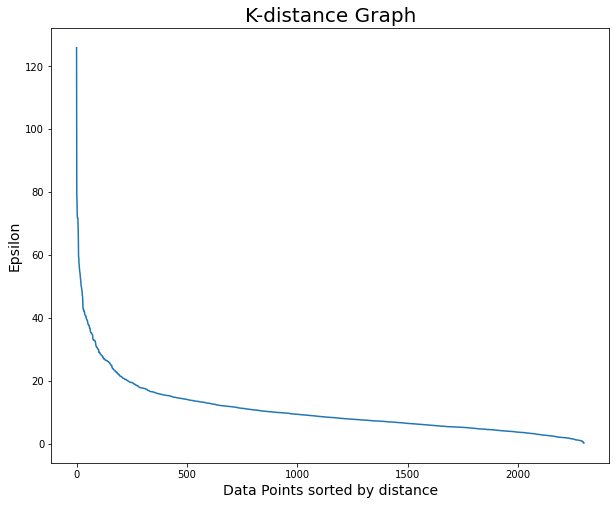

In [17]:
dbscan = DBSCAN()          # by default Eps = 0.5, MinPts = 5
dbscan.fit(dataset_np)

# cluster labels obtained from DBSCAN clustering
labels_dbscan = dbscan.labels_

# Finding optimal values of Eps and MinPts using k-distance graph
NN   = NearestNeighbors(n_neighbors=2)
nbrs = NN.fit(dataset_np)
distances, indices = nbrs.kneighbors(dataset_np)

# Plotting k-distance Graph
distances = np.sort(distances, axis=0) # sort in descending order
distances = distances[:,1]
distances = distances[::-1]            # reverse the sorted array to get it in ascending order
plt.figure(figsize=(10,8))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()


In [18]:
Eps = [20,30,50]
MinPts = 5
labels_dbscan_opt =[labels_dbscan]

for i in range(len(Eps)):
  dbscan_opt = DBSCAN(eps=Eps[i],min_samples=MinPts)
  dbscan_opt.fit(dataset_np)

  # cluster labels obtained from DBSCAN clustering with appropriate parameters
  db_labels = dbscan_opt.labels_
  labels_dbscan_opt.append(db_labels)


## Spectral clustering:

In [19]:
spect = SpectralClustering(n_clusters = n_clusters,affinity='nearest_neighbors')
spect.fit(dataset_np)

# cluster labels obtained from Spectral clustering
labels_spect = spect.labels_

## Plotting of clusters formed by above clustering methods:

<IPython.core.display.Javascript object>

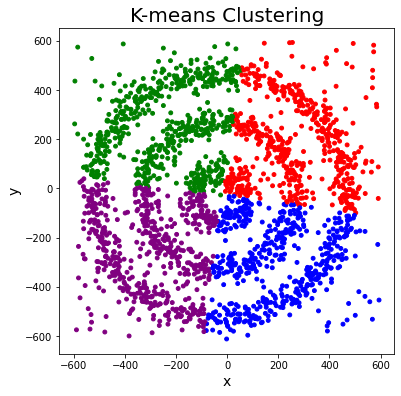

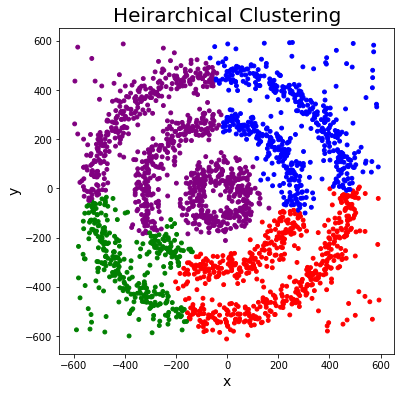

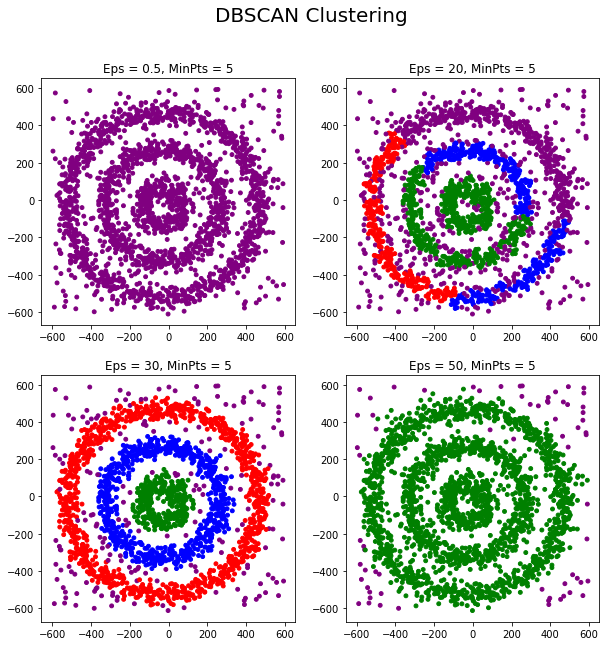

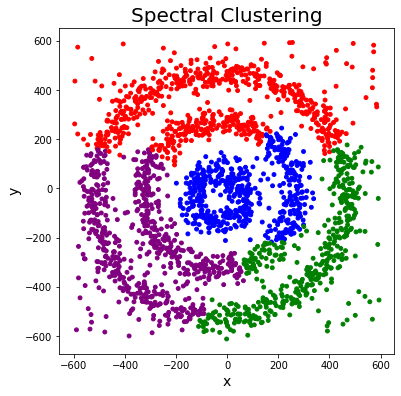

In [20]:
avoid_scroll_output_window()
# ==================== Dataset 2 ===========================

colors=['purple','red','blue','green']

# K-means clustering
plt.figure(figsize=(6,6))
plt.scatter(dataset_np[:,0],dataset_np[:,1],c=labels_kmeans,cmap=matplotlib.colors.ListedColormap(colors),s=15)
plt.title('K-means Clustering',fontsize=20)
plt.xlabel('x',fontsize=14)
plt.ylabel('y',fontsize=14)
plt.show()

# Heirarchical clustering
plt.figure(figsize=(6,6))
plt.scatter(dataset_np[:,0],dataset_np[:,1],c=labels_hr,cmap=matplotlib.colors.ListedColormap(colors),s=15)
plt.title('Heirarchical Clustering',fontsize=20)
plt.xlabel('x',fontsize=14)
plt.ylabel('y',fontsize=14)
plt.show()

# DBSCAN clustering

fig = plt.figure(figsize=(10, 10))
fig.suptitle("DBSCAN Clustering",fontsize=20)
ax1=fig.add_subplot(221)
plt.scatter(dataset_np[:,0],dataset_np[:,1],c=labels_dbscan_opt[0],cmap=matplotlib.colors.ListedColormap(colors),s=15)
ax1.title.set_text(f'Eps = 0.5, MinPts = {MinPts}')
ax2=fig.add_subplot(222)
plt.scatter(dataset_np[:,0],dataset_np[:,1],c=labels_dbscan_opt[1],cmap=matplotlib.colors.ListedColormap(colors),s=15)
ax2.title.set_text(f'Eps = {Eps[0]}, MinPts = {MinPts}')
ax3=fig.add_subplot(223)
plt.scatter(dataset_np[:,0],dataset_np[:,1],c=labels_dbscan_opt[2],cmap=matplotlib.colors.ListedColormap(colors),s=15)
ax3.title.set_text(f'Eps = {Eps[1]}, MinPts = {MinPts}')
ax4=fig.add_subplot(224)
plt.scatter(dataset_np[:,0],dataset_np[:,1],c=labels_dbscan_opt[3],cmap=matplotlib.colors.ListedColormap(colors),s=15)
ax4.title.set_text(f'Eps = {Eps[2]}, MinPts = {MinPts}')
plt.show()


# Spectral clustering
plt.figure(figsize=(6,6))
plt.scatter(dataset_np[:,0],dataset_np[:,1],c=labels_spect,cmap=matplotlib.colors.ListedColormap(colors),s=15)
plt.title('Spectral Clustering',fontsize=20)
plt.xlabel('x',fontsize=14)
plt.ylabel('y',fontsize=14)
plt.show()


# Comparision of clustering algorithms on different datasets:

<IPython.core.display.Javascript object>

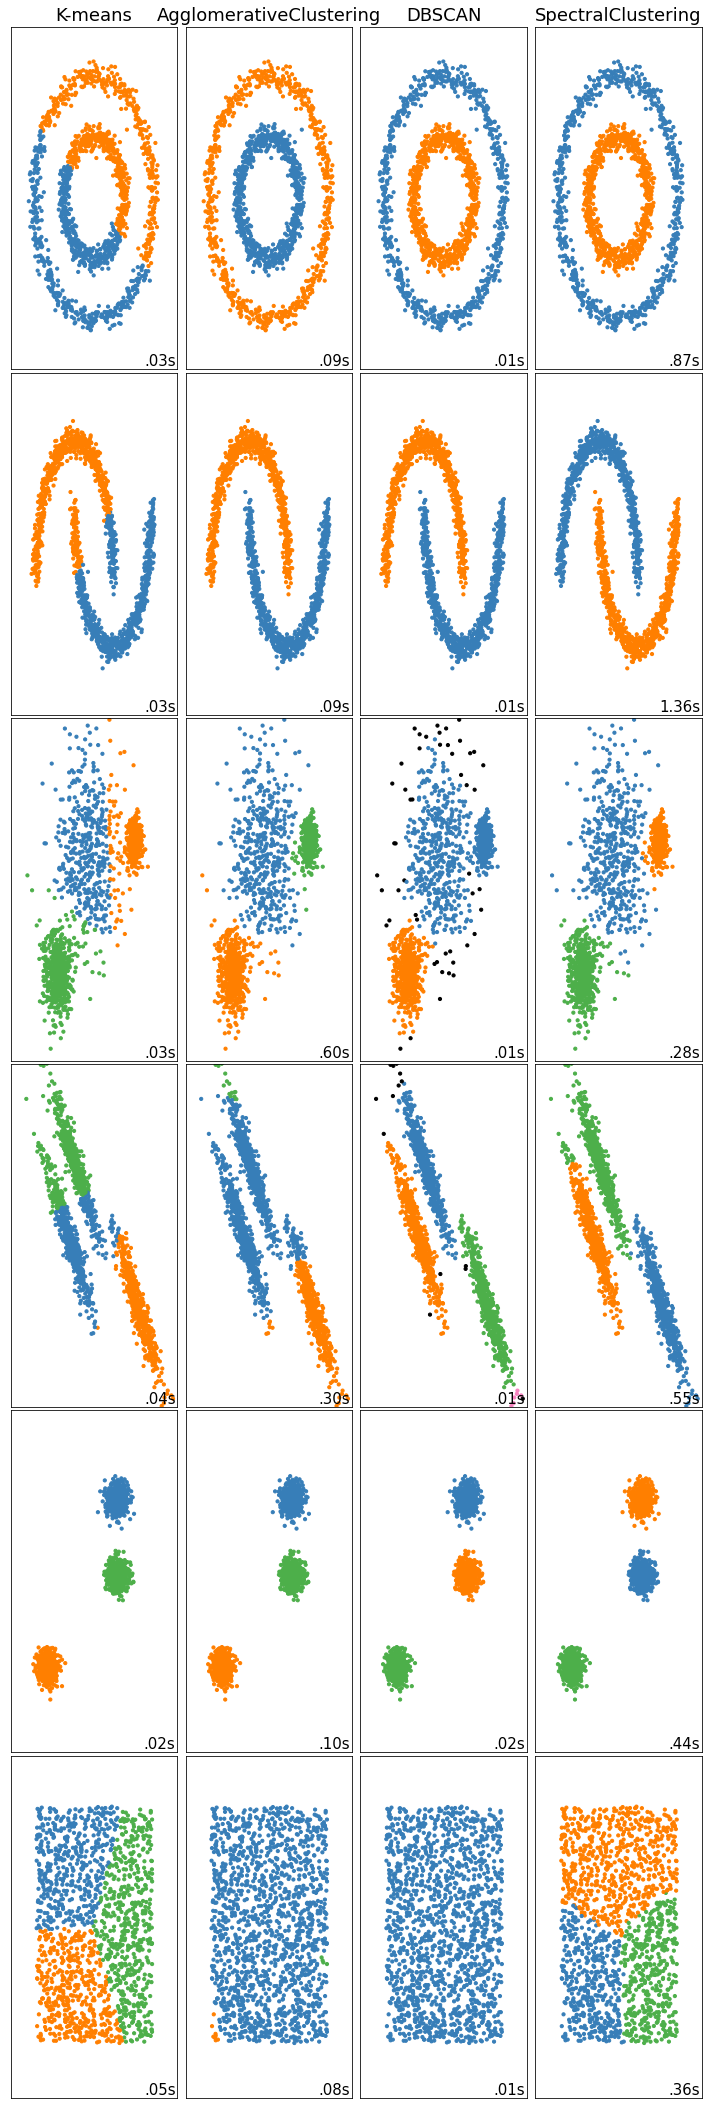

In [21]:
import time
import warnings
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)
avoid_scroll_output_window()
# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============

n_samples     = 1500

# Noisy concentric circles
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,noise=.05)

# Noisy moons
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)

# blobs
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)

no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y           = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso        = np.dot(X, transformation)
aniso          = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,cluster_std=[1.0, 2.5, 0.5],random_state=random_state)

# ============ Set up cluster parameters ============

plt.figure(figsize=(10, 30))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3,
                'min_samples': 20,
                'xi': 0.05,
                'min_cluster_size': 0.1}

datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2,
                     'min_samples': 20, 'xi': 0.25}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2,
              'min_samples': 5, 'xi': 0.035, 'min_cluster_size': .2}),
    (aniso, {'eps': .15, 'n_neighbors': 2,
             'min_samples': 20, 'xi': 0.1, 'min_cluster_size': .2}),
    (blobs, {}),
    (no_structure, {})]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(X, n_neighbors=params['n_neighbors'], include_self=False)

    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============ Create cluster objects ============

    kmeans          = cluster.KMeans(n_clusters=params['n_clusters'])
    ward            = cluster.AgglomerativeClustering(n_clusters=params['n_clusters'], linkage='ward',connectivity=connectivity)
    average_linkage = cluster.AgglomerativeClustering(linkage="average", affinity="manhattan",n_clusters=params['n_clusters'], connectivity=connectivity)
    dbscan          = cluster.DBSCAN(eps=params['eps'])
    spectral        = cluster.SpectralClustering(n_clusters=params['n_clusters'], eigen_solver='arpack',affinity="nearest_neighbors")
    
    clustering_algorithms = (
        ('K-means', kmeans),
        ('AgglomerativeClustering', average_linkage),
        ('DBSCAN', dbscan),
        ('SpectralClustering', spectral),
        
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets),len(clustering_algorithms), plot_num)
        if i_dataset == 0:plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']),int(max(y_pred) + 1))))

        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),transform=plt.gca().transAxes, size=15,horizontalalignment='right')
        plot_num += 1

plt.show()